In [ ]:
from torch.nn.utils.rnn import pad_sequence
import re
import string
import json
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from torchmetrics.classification import MulticlassF1Score
import sklearn.metrics
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import math
from math import *
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import os
from glob import glob
from tqdm.auto import tqdm
from torch.optim import AdamW
import matplotlib.pyplot as plt
from collections import defaultdict

In [ ]:
from transformers import set_seed
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

## Preprocess Data

In [ ]:
def tok_to_idx(toks):
    return{tok: idx for idx, tok in enumerate(toks)}

def idx_to_tok(toks):
    idx_dict = tok_to_idx(toks)
    return {idx: tok for tok, idx in idx_dict.items()}

In [ ]:
def tokenization(data, with_bos, without_comma):
    output = []
    for dic in data:
      tok_re = re.compile(r"[∀∃]|¬|[,()∧∨→]|[A-Z]|[a-z]")
      tok = tok_re.findall(dic['FOL'])
      tok = [t for t in tok if t!="," ]
      # tok = ["§"] + tok
      output.append(tok)
    return output

In [ ]:
def detokenization(idx_seq, idx2tok):
    tokens = [idx2tok[i] for i in idx_seq]
    return " ".join(tokens)

In [ ]:
def mapping(data, tok2idx, with_bos, without_comma):
    output = []
    tokizer = tokenization(data, with_bos, without_comma)
    for i in tokizer:
        item = []
        for tok in i:
            idx = tok2idx[tok]
            item.append(idx)
        output.append(item)
    return output

In [ ]:
def reconstruct_data(data, tok2idx, with_bos, without_comma):
    mapped_ids = mapping(data, tok2idx, with_bos, without_comma)
    for org, ids in zip(data, mapped_ids):
        org["input_ids"] = ids
    return data

In [ ]:
def padding(batch_data, tok2idx):
    FOL, QD = zip(*batch_data)
    labels = torch.tensor(QD, dtype=torch.long)
    FOL_ts = [torch.tensor(f, dtype=torch.long) for f in FOL]
    inputs = pad_sequence(FOL_ts, batch_first=True, padding_value=tok2idx['<pad>'])

    return {"input_ids": inputs,
         "labels": labels}

In [ ]:
def preprocess(data_name, with_bos, without_comma):
    data = []
    with open(data_name, "r", encoding="utf-8") as f:
        for line in f:
            item = json.loads(line)
            data.append(item)

    data_new = reconstruct_data(data, tok2idx, with_bos, without_comma)
    inputs = [item["input_ids"] for item in data_new]
    labels = [(int(item["QD"])-1) for item in data_new]
    pairs = list(zip(inputs, labels))
    train_pairs, other_pairs = train_test_split(pairs, test_size=0.2, random_state=42)
    valid_pairs, test_pairs = train_test_split(other_pairs, test_size=0.5, random_state=42)
    train_loader = DataLoader(train_pairs, batch_size=32, drop_last = True, collate_fn = lambda batch: padding(batch, tok2idx))
    valid_loader = DataLoader(valid_pairs, batch_size=32, drop_last = True, collate_fn = lambda batch: padding(batch, tok2idx))
    test_loader = DataLoader(test_pairs, batch_size=32, drop_last = True, collate_fn = lambda batch: padding(batch, tok2idx))
    return train_loader, valid_loader, test_loader

In [ ]:
symbol = ['<pad>','§','∀','∃','∧','∨','→','(',')',',']
lowercase = list(string.ascii_lowercase)
uppercase = list(string.ascii_uppercase)

In [ ]:
toks = symbol + lowercase + uppercase
enc_voc_size = len(toks)
tok2idx = tok_to_idx(toks)
idx2tok = idx_to_tok(toks)
src_pad_idx = tok2idx['<pad>']

In [ ]:
uni_id = tok2idx['∀']
exi_id = tok2idx['∃']
open_id = tok2idx['(']
close_id = tok2idx[')']

## Model

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, vocb_size, max_len, d_model, device, dropout):
        super().__init__()
        self.we = nn.Embedding(vocb_size, d_model)
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model))
        self.device = device
        self.dropout = nn.Dropout(p=dropout)
        self.scale = math.sqrt(d_model)

    def forward(self, x):
        batch_size, seq_len = x.size()
        tok = self.we(x) * self.scale
        pos = self.pe[:, :seq_len, :].to(device=self.device)
        embedding = tok + pos.expand(batch_size, seq_len, -1)
        return self.dropout(embedding)

In [ ]:
class Classifier(nn.Module):

    def __init__(self, vocb_size, max_len, d_model, n_heads, n_classes, dropout):
        super().__init__()
        self.emb = Embeddings(vocb_size, max_len, d_model, device, dropout)
        self.encoder = TransformerEncoderWithHooks(d_model=d_model,
                              nhead=n_heads,
                              num_layers=n_layers,
                              dim_feedforward=256,
                              dropout=0)

        self.classifierhead = nn.Linear(d_model, n_classes)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        emb = self.encoder(self.emb(src), src_mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        pooled = emb.mean(dim=1)
        return self.classifierhead(pooled) # self.classifierhead(emb[:, 0, :])    #

In [ ]:
def save_attention_weights_hook_generator(layer_idx):

    def hook(module, input, output):
        if module.training:
            return None
        if not isinstance(output, tuple) or len(output) < 2 or output[1] is None:
            raise ValueError(f'Could not find attention weights in the output of the self-attention module {layer_idx}!')

        attention_weights_store[layer_idx] = output[1].detach().cpu()
    return hook

In [ ]:
class ExtractQKV():
  def __init__(self, transformer_encoder, logits_store=None, value_store=None):
    self.transformer_encoder = transformer_encoder
    self.logits_store = logits_store if logits_store is not None else defaultdict(list)
    self.value_store  = value_store  if value_store is not None  else defaultdict(list)
    self.register_hooks()

  def register_hooks(self):
    for idx, layer in enumerate(self.transformer_encoder.layers):
      layer.self_attn.register_forward_pre_hook(self.save_logits_hook(idx))
      layer.self_attn.register_forward_pre_hook(self.save_value_hook(idx))

  def save_logits_hook(self, layer_idx):
    def hook(module, inp):
      query, key, *_ = inp
      b_size, seq, d_model = query.shape
      head_dim = d_model // module.num_heads
      Wq = module.in_proj_weight[:d_model]
      bq = module.in_proj_bias[:d_model]
      Wk = module.in_proj_weight[d_model:2*d_model]
      bk = module.in_proj_bias[d_model:2*d_model]
      Q = F.linear(query, Wq, bq)
      K = F.linear(key, Wk, bk)
      Q = Q.view(b_size, seq, module.num_heads, head_dim).transpose(1,2)
      K = K.view(b_size, seq, module.num_heads, head_dim).transpose(1,2)
      score = torch.matmul(Q, K.transpose(-2,-1)) / math.sqrt(head_dim)
      self.logits_store[layer_idx].append(score.detach())
    return hook

  def save_value_hook(self, layer_idx):
    def hook(module, inp):
      value = inp[2]
      b_size, seq, d_model = value.shape
      head_dim = d_model // module.num_heads
      if hasattr(module, 'in_proj_weight'):
          Wv = module.in_proj_weight[2*d_model:3*d_model]
          bv = module.in_proj_bias[2*d_model:3*d_model]
          V = F.linear(value, Wv, bv)
      else:
          V = module.v_proj(value)
      V = V.view(b_size, seq, module.num_heads, head_dim).transpose(1,2)
      self.value_store[layer_idx].append(V.detach())
    return hook

In [ ]:
class MyTransformerEncoderLayer(nn.TransformerEncoderLayer):

    def _sa_block(self, x, attn_mask, key_padding_mask, **kwargs):
        x, attn_weights = self.self_attn(
            x, x, x,
            attn_mask=attn_mask,
            key_padding_mask=key_padding_mask,
            need_weights=True,
            average_attn_weights=False,
            **kwargs
        )
        return self.dropout1(x)

In [ ]:
class TransformerEncoderWithHooks(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, dropout):
        super().__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            layer = MyTransformerEncoderLayer(
                d_model=d_model,
                nhead=nhead,
                dim_feedforward=dim_feedforward,
                dropout=dropout,
                batch_first=True
            )

            mha_module = layer.self_attn

            mha_module.register_forward_hook(
                save_attention_weights_hook_generator(i))
            self.layers.append(layer)

        self.norm = nn.LayerNorm(d_model)
        self.qkv = ExtractQKV(
                transformer_encoder=self,
                logits_store=logits_store,
                value_store=value_store
              )

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        output = src
        attention_weights_store.clear()
        logits_store.clear()
        value_store.clear()
        for layer in self.layers:
             output = layer(output, src_mask=src_mask,
                      src_key_padding_mask=src_key_padding_mask)

        output = self.norm(output)
        return output

## Training

In [ ]:
def train(train_data, model, optimizer, loss_fn, device, with_mask):
    model.train()
    train_loss = torch.empty(len(train_data))
    for batch_step, items in tqdm(enumerate(train_data),
                              total=len(train_data),
                              desc='Train',
                              leave=False):
        optimizer.zero_grad()
        inputs = items["input_ids"].to(device)
        gold = items["labels"].to(device)
        if with_mask:
            mask = (inputs==0)
        logits = model(src=inputs, src_mask=None, src_key_padding_mask=mask)
        loss = loss_fn(logits, gold)
        loss.backward()
        optimizer.step()
        train_loss[batch_step]= loss.item()

    with torch.no_grad():
        emb_weight = model.emb.we.weight.detach().cpu()
        # print(model.emb.we.weight.requires_grad)
        vec_uni = emb_weight[uni_id]
        vec_exi = emb_weight[exi_id]
        cos = F.cosine_similarity(vec_uni, vec_exi, dim=0).item()
        print(f'Quantifier cos_similarity: {cos:.4f}')

    return train_loss.mean().item(),cos

In [ ]:
def validate(valid_data, model, loss_fn, device, topk, with_mask):
    model.eval()
    macroScore = MulticlassF1Score(num_classes=3, average='macro').to(device)
    perScore = MulticlassF1Score(num_classes=3, average=None).to(device)

    all_probs, all_preds, topk_probs  = [], [], []
    valid_loss = torch.empty(len(valid_data))
    valid_accuracy = torch.empty(len(valid_data))
    valid_macroF1 = torch.empty(len(valid_data))
    valid_perF1 = torch.empty(len(valid_data), 3)

    with torch.no_grad():

        for batch_step, items in tqdm(enumerate(valid_data),
                                total=len(valid_data),
                                desc='Valid',
                                leave=False):

            inputs = items["input_ids"].to(device)
            gold = items["labels"].to(device)
            if with_mask:
                mask = (inputs==0)
            logits = model(src=inputs, src_mask=None, src_key_padding_mask=mask)
            preds = torch.argmax(logits, dim=-1)
            probs = F.softmax(logits, dim=-1)
            topk_val, topk_idx = probs.topk(topk, dim=-1)

            all_preds.append(preds)
            topk_probs.append((topk_val, topk_idx))

            loss = loss_fn(logits, gold)
            macroF1 = macroScore(preds, gold)
            perF1 = perScore(preds, gold)

            valid_loss[batch_step] = loss.item()
            valid_accuracy[batch_step] = ((preds == gold).sum().item()) / gold.size(0)
            valid_macroF1[batch_step] = macroF1
            valid_perF1[batch_step] = perF1
    return valid_loss.mean().item(), valid_accuracy.mean().item(), valid_macroF1.mean().item(), valid_perF1.mean(dim=0), all_preds, topk_probs

In [ ]:
def main(train_data, valid_data, epoch, best_acc, early_stop, topk, with_mask):
    train_losses, valid_losses, valid_accuracies = [], [], []
    valid_perF1s, valid_macroF1s = [], []
    quanti_cos = []
    lr_string = abs(int(log10(lr)))
    last_improve = 0
    print(data_name)
    for step in tqdm(range(epoch)):
        train_loss, cos = train(train_data=train_data, model=model, optimizer=optimizer, loss_fn=loss_fn, device=device, with_mask=with_mask)
        valid_loss, valid_acc, valid_macroF1, valid_perF1, all_preds, topk_probs = validate(valid_data=valid_data, model=model, loss_fn=loss_fn, device=device, topk=topk, with_mask=with_mask)
        print(f'Epoch: {step + 1}, Train Loss: {train_loss:.2f}, Val Loss: {valid_loss:.2f}')
        print(f'Val Accuracy: {valid_acc:.2f}, Val macroF1: {valid_macroF1:.2f}')
        if isinstance(valid_perF1, torch.Tensor):
            valid_perF1_ls = valid_perF1.cpu().tolist()
        else:
            valid_perF1_ls = list(valid_perF1)

        print(f'Val_F1 QD=1: {valid_perF1_ls[0]:.2f}, ',
          f'QD=2: {valid_perF1_ls[1]:.2f}, ',
          f'QD=3: {valid_perF1_ls[2]:.2f}')
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)
        valid_perF1s.append(valid_perF1_ls)
        valid_macroF1s.append(valid_macroF1)
        quanti_cos.append(cos)

        if valid_acc > best_acc:
            best_acc = valid_acc
            last_improve = step

            for path in glob('*.pt'):
                os.remove(path)
            torch.save({'best_model': model.state_dict()},
                        f'{data_name}_epoch{step+1}_lr{lr_string}_{valid_acc:.2f}.pt')
        else:
            if step - last_improve == early_stop:
                print(f'Early stopping: no improvement for {early_stop} epochs.')
                break

    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.plot(valid_macroF1s, label='Valid macro_F1score')
    plt.xlabel("Epochs")
    plt.ylabel("Metric")
    plt.legend()
    plt.grid(True)
    plt.show()

    for i in range(3):
        per_class = [per[i] for per in valid_perF1s]
        plt.plot(range(1, len(valid_perF1s)+1), per_class, label=f'QD={i+1}')

    plt.xlabel('Epochs')
    plt.ylabel('Per-class F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(range(1, len(quanti_cos)+1), quanti_cos, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Cosine similarity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return all_preds, topk_probs,valid_accuracies, valid_macroF1s, valid_perF1s

In [ ]:
def load_checkpoint(path, device,model):
    state = torch.load(path, map_location=device)
    model.load_state_dict(state['best_model'])

    model.eval()
    return model

## Test

In [ ]:
def test(test_data, model, loss_fn, device, topk, with_mask):
    model.eval()
    macroScore = MulticlassF1Score(num_classes=3, average='macro').to(device)
    perScore = MulticlassF1Score(num_classes=3, average=None).to(device)

    all_probs, all_preds, topk_probs  = [], [], []
    test_accuracy = torch.empty(len(test_data))
    test_macroF1 = torch.empty(len(test_data))
    test_perF1 = torch.empty(len(test_data), 3)


    with torch.no_grad():
        for batch_step, items in tqdm(enumerate(test_data),
                                total=len(test_data),
                                desc='Test',
                                leave=False):

            inputs = items["input_ids"].to(device)
            gold = items["labels"].to(device)
            if with_mask:
                mask = (inputs==0)
            logits = model(src=inputs, src_mask=None, src_key_padding_mask=mask)
            preds = torch.argmax(logits, dim=-1)
            probs = F.softmax(logits, dim=-1)
            topk_val, topk_idx = probs.topk(topk, dim=-1)

            all_preds.append(preds)
            topk_probs.append((topk_val, topk_idx))

            macroF1 = macroScore(preds, gold)
            perF1 = perScore(preds, gold)

            test_accuracy[batch_step] = ((preds == gold).sum().item()) / gold.size(0)
            test_macroF1[batch_step] = macroF1
            test_perF1[batch_step] = perF1
    return test_accuracy.mean().item(), test_macroF1.mean().item(), test_perF1.mean(dim=0), all_preds, topk_probs

## Function: Draw Plot

In [ ]:
def draw_confusion_matrix(loader, all_preds, name, display_labels=[1,2,3], figsize=(4,4)):
    golds = []
    for batch in loader:
        lbl = batch['labels'] if isinstance(batch, dict) else batch[1]
        golds.append(lbl.detach().cpu().numpy())
    golds = np.concatenate(golds, axis=0)

    preds_list = []
    for p in all_preds:
        if torch.is_tensor(p):
            preds_list.append(p.detach().cpu().numpy())
        else:
            preds_list.append(np.array(p))
    preds = np.concatenate(preds_list, axis=0)

    assert preds.shape[0] == golds.shape[0]

    labels = np.unique(golds)
    cm = confusion_matrix(golds, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)

    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")
    plt.show()

In [ ]:
def check_attention_weights():
    print("\n--- Stored Attention Weights ---")
    if not attention_weights_store:
        print("No attention weights were captured.")
    else:
        for layer_idx, weights in attention_weights_store.items():
            # Expected shape: (batch_size, num_heads, seq_len, seq_len)
            print(f"Layer {layer_idx}: Weights = {weights.shape}")
            # Check that attention weights in the first input sum to 1.
            print(f"Weight row sums = {weights[0].sum(dim=-1).flatten()}")

In [ ]:
def attetion_info(sample_idx, all_preds, with_pad=False, with_mask=False):
    pad_tok = "<pad>"
    input_id = last_inputs[sample_idx].tolist()
    input_token = detokenization(input_id, idx2tok)
    tokens = [idx2tok[i] for i in input_id]
    if with_mask:
        tok = [t for t in tokens if t != pad_tok]
    else:
        tok = ["-" if t == pad_tok else t for t in tokens]
    label = last_labels[sample_idx].tolist()
    last_preds = all_preds[-1]
    pred = last_preds[sample_idx].tolist()
    print("Input token:", "".join(tok))
    print("Label:", (int(label)+1))
    print("Prediction:", pred+1)

    for layer_idx, weights in attention_weights_store.items():
        batch_size, head, seq_len, _ = weights.shape
        x = np.arange(len(tok))

        for h in range(head):
            attn = weights[sample_idx, h, :, :].numpy()
            fig, ax = plt.subplots(figsize=(4,4))
            im = ax.imshow(attn, aspect='auto', vmin=0, vmax=1) # [:len(tok), :len(tok)]
            for i in range(len(tok)):
              for j in range(len(tok)):
                val = attn[i, j]
                ax.text(j, i, f"{val:.2f}",
                    ha="center", va="center",
                    color="black" if val>0.5 else "white",
                    fontsize=6)
            ax.set_xticks(x)
            ax.set_xticklabels(tok, fontsize=8)
            ax.set_yticks(x)
            ax.set_yticklabels(tok, fontsize=8)
            ax.set_title(f"Sample:{sample_idx}, Layer:{layer_idx}, Head:{h}")
            ax.set_xlabel("Key Position")
            ax.set_ylabel("Query Position")
            fig.colorbar(im, ax=ax)
            plt.tight_layout()
            plt.show()

            # filename = (f"{save_dir}/{data_name}_{n_layers}L{n_heads}H_"
            #        f"Sample{sample_idx}_L{layer_idx}H{h}.png")
            # plt.savefig(filename, dpi=800, bbox_inches='tight')

In [ ]:
def error_case(all_preds, topk_probs, with_mask=True):
    last_preds = all_preds[-1]
    top, logit_idx= topk_probs[-1]
    logit_idx = logit_idx+1
    for idx, item in enumerate(last_preds):
        if item != (last_labels[idx]):
            print(f"-----Error{idx}:{all_token[idx]}-----")
            print(f"label:{last_labels[idx]+1}, prediction:{item+1}.")
            print(f"logits:{top[idx].tolist()},logit_idx:{logit_idx[idx].tolist()}")

# Run Main

## Parameter setting

In [ ]:
# model parameter
batch_size = 32
max_len = 28
d_model = 256
n_classes = 3
dropout = 0
topk = 3

In [ ]:
# optimizer parameter
early_stop = 30

In [ ]:
device = "cuda" # if torch.cuda.is_available() else "cpu"
loss_fn = nn.CrossEntropyLoss()

## Standard-1

In [ ]:
with open("Type1_M.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

In [ ]:
data_name = "Type1"

In [ ]:
train_data1, valid_data1, test_data1 = preprocess("Type1_M.json", with_bos=True, without_comma=False)

In [ ]:
lr = 1e-5
epoch = 30
n_layers = 2
n_heads = 2

In [ ]:
torch.cuda.empty_cache()
attention_weights_store = defaultdict(list)
logits_store = defaultdict(list)
value_store = defaultdict(list)

In [ ]:
model = Classifier(vocb_size=enc_voc_size,
          max_len=max_len,
          d_model=d_model,
          n_heads=n_heads,
          n_classes=n_classes,
          dropout=dropout).to(device)

optimizer = AdamW(params=model.parameters(), lr=lr)

Type1


  0%|          | 0/100 [00:00<?, ?it/s]

Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1619


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 1.18, Val Loss: 1.22
Val Accuracy: 0.30, Val macroF1: 0.17
Val_F1 QD=1: 0.00,  QD=2: 0.48,  QD=3: 0.04


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1626


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 1.17, Val Loss: 1.20
Val Accuracy: 0.30, Val macroF1: 0.18
Val_F1 QD=1: 0.00,  QD=2: 0.48,  QD=3: 0.06


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1633


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 1.15, Val Loss: 1.19
Val Accuracy: 0.30, Val macroF1: 0.19
Val_F1 QD=1: 0.00,  QD=2: 0.48,  QD=3: 0.08


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1640


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 1.14, Val Loss: 1.17
Val Accuracy: 0.31, Val macroF1: 0.19
Val_F1 QD=1: 0.00,  QD=2: 0.48,  QD=3: 0.10


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1646


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 1.13, Val Loss: 1.16
Val Accuracy: 0.30, Val macroF1: 0.20
Val_F1 QD=1: 0.01,  QD=2: 0.47,  QD=3: 0.11


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1651


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 1.12, Val Loss: 1.15
Val Accuracy: 0.31, Val macroF1: 0.22
Val_F1 QD=1: 0.02,  QD=2: 0.47,  QD=3: 0.18


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1656


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 1.11, Val Loss: 1.14
Val Accuracy: 0.32, Val macroF1: 0.24
Val_F1 QD=1: 0.03,  QD=2: 0.46,  QD=3: 0.23


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1661


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 1.10, Val Loss: 1.12
Val Accuracy: 0.33, Val macroF1: 0.25
Val_F1 QD=1: 0.05,  QD=2: 0.46,  QD=3: 0.25


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1664


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 1.09, Val Loss: 1.11
Val Accuracy: 0.34, Val macroF1: 0.27
Val_F1 QD=1: 0.07,  QD=2: 0.45,  QD=3: 0.29


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1668


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 1.08, Val Loss: 1.10
Val Accuracy: 0.36, Val macroF1: 0.31
Val_F1 QD=1: 0.11,  QD=2: 0.46,  QD=3: 0.36


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1671


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 1.07, Val Loss: 1.09
Val Accuracy: 0.38, Val macroF1: 0.34
Val_F1 QD=1: 0.15,  QD=2: 0.46,  QD=3: 0.40


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1673


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 12, Train Loss: 1.06, Val Loss: 1.08
Val Accuracy: 0.38, Val macroF1: 0.35
Val_F1 QD=1: 0.17,  QD=2: 0.45,  QD=3: 0.43


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1676


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 13, Train Loss: 1.05, Val Loss: 1.07
Val Accuracy: 0.39, Val macroF1: 0.37
Val_F1 QD=1: 0.21,  QD=2: 0.44,  QD=3: 0.45


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1679


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 14, Train Loss: 1.04, Val Loss: 1.06
Val Accuracy: 0.42, Val macroF1: 0.41
Val_F1 QD=1: 0.27,  QD=2: 0.44,  QD=3: 0.51


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1681


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 15, Train Loss: 1.04, Val Loss: 1.05
Val Accuracy: 0.45, Val macroF1: 0.44
Val_F1 QD=1: 0.34,  QD=2: 0.45,  QD=3: 0.53


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1684


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 16, Train Loss: 1.03, Val Loss: 1.04
Val Accuracy: 0.46, Val macroF1: 0.45
Val_F1 QD=1: 0.36,  QD=2: 0.45,  QD=3: 0.55


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1687


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 17, Train Loss: 1.02, Val Loss: 1.03
Val Accuracy: 0.48, Val macroF1: 0.48
Val_F1 QD=1: 0.39,  QD=2: 0.46,  QD=3: 0.58


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1689


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 18, Train Loss: 1.01, Val Loss: 1.02
Val Accuracy: 0.51, Val macroF1: 0.51
Val_F1 QD=1: 0.43,  QD=2: 0.48,  QD=3: 0.63


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1692


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 19, Train Loss: 1.00, Val Loss: 1.01
Val Accuracy: 0.54, Val macroF1: 0.54
Val_F1 QD=1: 0.47,  QD=2: 0.48,  QD=3: 0.66


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1695


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 20, Train Loss: 0.99, Val Loss: 1.00
Val Accuracy: 0.56, Val macroF1: 0.56
Val_F1 QD=1: 0.50,  QD=2: 0.50,  QD=3: 0.69


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1699


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 21, Train Loss: 0.98, Val Loss: 0.99
Val Accuracy: 0.59, Val macroF1: 0.59
Val_F1 QD=1: 0.54,  QD=2: 0.52,  QD=3: 0.72


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1702


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 22, Train Loss: 0.97, Val Loss: 0.98
Val Accuracy: 0.61, Val macroF1: 0.62
Val_F1 QD=1: 0.58,  QD=2: 0.53,  QD=3: 0.74


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1705


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 23, Train Loss: 0.95, Val Loss: 0.97
Val Accuracy: 0.63, Val macroF1: 0.63
Val_F1 QD=1: 0.60,  QD=2: 0.55,  QD=3: 0.76


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1709


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 24, Train Loss: 0.94, Val Loss: 0.95
Val Accuracy: 0.64, Val macroF1: 0.65
Val_F1 QD=1: 0.61,  QD=2: 0.55,  QD=3: 0.78


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1712


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 25, Train Loss: 0.93, Val Loss: 0.94
Val Accuracy: 0.67, Val macroF1: 0.67
Val_F1 QD=1: 0.62,  QD=2: 0.57,  QD=3: 0.81


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1715


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 26, Train Loss: 0.92, Val Loss: 0.93
Val Accuracy: 0.68, Val macroF1: 0.68
Val_F1 QD=1: 0.64,  QD=2: 0.59,  QD=3: 0.82


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1719


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 27, Train Loss: 0.91, Val Loss: 0.92
Val Accuracy: 0.70, Val macroF1: 0.70
Val_F1 QD=1: 0.65,  QD=2: 0.60,  QD=3: 0.84


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1722


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 28, Train Loss: 0.90, Val Loss: 0.91
Val Accuracy: 0.73, Val macroF1: 0.73
Val_F1 QD=1: 0.67,  QD=2: 0.65,  QD=3: 0.87


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1725


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 29, Train Loss: 0.89, Val Loss: 0.90
Val Accuracy: 0.74, Val macroF1: 0.74
Val_F1 QD=1: 0.68,  QD=2: 0.66,  QD=3: 0.88


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1728


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 30, Train Loss: 0.88, Val Loss: 0.89
Val Accuracy: 0.75, Val macroF1: 0.75
Val_F1 QD=1: 0.69,  QD=2: 0.66,  QD=3: 0.89


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1730


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 31, Train Loss: 0.87, Val Loss: 0.88
Val Accuracy: 0.76, Val macroF1: 0.76
Val_F1 QD=1: 0.70,  QD=2: 0.68,  QD=3: 0.90


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1732


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 32, Train Loss: 0.86, Val Loss: 0.87
Val Accuracy: 0.78, Val macroF1: 0.77
Val_F1 QD=1: 0.71,  QD=2: 0.70,  QD=3: 0.92


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1734


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 33, Train Loss: 0.85, Val Loss: 0.86
Val Accuracy: 0.78, Val macroF1: 0.78
Val_F1 QD=1: 0.70,  QD=2: 0.71,  QD=3: 0.92


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1736


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 34, Train Loss: 0.84, Val Loss: 0.85
Val Accuracy: 0.79, Val macroF1: 0.79
Val_F1 QD=1: 0.71,  QD=2: 0.72,  QD=3: 0.93


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1738


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 35, Train Loss: 0.83, Val Loss: 0.84
Val Accuracy: 0.80, Val macroF1: 0.79
Val_F1 QD=1: 0.72,  QD=2: 0.73,  QD=3: 0.93


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1739


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 36, Train Loss: 0.82, Val Loss: 0.83
Val Accuracy: 0.81, Val macroF1: 0.80
Val_F1 QD=1: 0.74,  QD=2: 0.74,  QD=3: 0.93


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1740


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 37, Train Loss: 0.81, Val Loss: 0.82
Val Accuracy: 0.81, Val macroF1: 0.81
Val_F1 QD=1: 0.75,  QD=2: 0.75,  QD=3: 0.93


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1741


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 38, Train Loss: 0.80, Val Loss: 0.81
Val Accuracy: 0.82, Val macroF1: 0.82
Val_F1 QD=1: 0.76,  QD=2: 0.76,  QD=3: 0.94


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1742


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 39, Train Loss: 0.79, Val Loss: 0.80
Val Accuracy: 0.83, Val macroF1: 0.83
Val_F1 QD=1: 0.78,  QD=2: 0.77,  QD=3: 0.94


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1743


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 40, Train Loss: 0.78, Val Loss: 0.80
Val Accuracy: 0.83, Val macroF1: 0.83
Val_F1 QD=1: 0.78,  QD=2: 0.77,  QD=3: 0.94


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1743


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 41, Train Loss: 0.77, Val Loss: 0.79
Val Accuracy: 0.83, Val macroF1: 0.83
Val_F1 QD=1: 0.78,  QD=2: 0.77,  QD=3: 0.94


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1743


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 42, Train Loss: 0.76, Val Loss: 0.78
Val Accuracy: 0.84, Val macroF1: 0.83
Val_F1 QD=1: 0.78,  QD=2: 0.77,  QD=3: 0.94


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1743


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 43, Train Loss: 0.75, Val Loss: 0.77
Val Accuracy: 0.85, Val macroF1: 0.84
Val_F1 QD=1: 0.80,  QD=2: 0.78,  QD=3: 0.94


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1744


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 44, Train Loss: 0.74, Val Loss: 0.76
Val Accuracy: 0.85, Val macroF1: 0.85
Val_F1 QD=1: 0.81,  QD=2: 0.79,  QD=3: 0.94


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1744


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 45, Train Loss: 0.74, Val Loss: 0.76
Val Accuracy: 0.85, Val macroF1: 0.85
Val_F1 QD=1: 0.81,  QD=2: 0.79,  QD=3: 0.95


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1743


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 46, Train Loss: 0.73, Val Loss: 0.75
Val Accuracy: 0.85, Val macroF1: 0.85
Val_F1 QD=1: 0.81,  QD=2: 0.79,  QD=3: 0.95


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1743


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 47, Train Loss: 0.72, Val Loss: 0.74
Val Accuracy: 0.86, Val macroF1: 0.86
Val_F1 QD=1: 0.81,  QD=2: 0.80,  QD=3: 0.96


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1743


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 48, Train Loss: 0.71, Val Loss: 0.74
Val Accuracy: 0.87, Val macroF1: 0.86
Val_F1 QD=1: 0.82,  QD=2: 0.81,  QD=3: 0.96


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1742


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 49, Train Loss: 0.70, Val Loss: 0.73
Val Accuracy: 0.88, Val macroF1: 0.88
Val_F1 QD=1: 0.83,  QD=2: 0.83,  QD=3: 0.97


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1742


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 50, Train Loss: 0.70, Val Loss: 0.72
Val Accuracy: 0.89, Val macroF1: 0.88
Val_F1 QD=1: 0.84,  QD=2: 0.84,  QD=3: 0.97


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1742


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 51, Train Loss: 0.69, Val Loss: 0.71
Val Accuracy: 0.90, Val macroF1: 0.90
Val_F1 QD=1: 0.85,  QD=2: 0.85,  QD=3: 0.98


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1742


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 52, Train Loss: 0.68, Val Loss: 0.71
Val Accuracy: 0.90, Val macroF1: 0.90
Val_F1 QD=1: 0.87,  QD=2: 0.86,  QD=3: 0.98


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1743


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 53, Train Loss: 0.68, Val Loss: 0.70
Val Accuracy: 0.92, Val macroF1: 0.91
Val_F1 QD=1: 0.89,  QD=2: 0.87,  QD=3: 0.98


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1744


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 54, Train Loss: 0.67, Val Loss: 0.69
Val Accuracy: 0.92, Val macroF1: 0.92
Val_F1 QD=1: 0.89,  QD=2: 0.88,  QD=3: 0.98


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1746


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 55, Train Loss: 0.66, Val Loss: 0.69
Val Accuracy: 0.92, Val macroF1: 0.92
Val_F1 QD=1: 0.90,  QD=2: 0.88,  QD=3: 0.98


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1748


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 56, Train Loss: 0.65, Val Loss: 0.68
Val Accuracy: 0.93, Val macroF1: 0.93
Val_F1 QD=1: 0.91,  QD=2: 0.90,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1750


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 57, Train Loss: 0.65, Val Loss: 0.67
Val Accuracy: 0.94, Val macroF1: 0.93
Val_F1 QD=1: 0.91,  QD=2: 0.90,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1753


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 58, Train Loss: 0.64, Val Loss: 0.67
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.91,  QD=2: 0.91,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1756


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 59, Train Loss: 0.63, Val Loss: 0.66
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.91,  QD=2: 0.91,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1759


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 60, Train Loss: 0.62, Val Loss: 0.65
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.91,  QD=2: 0.91,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1764


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 61, Train Loss: 0.62, Val Loss: 0.64
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.92,  QD=2: 0.91,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1768


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 62, Train Loss: 0.61, Val Loss: 0.64
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.92,  QD=2: 0.92,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1773


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 63, Train Loss: 0.60, Val Loss: 0.63
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.92,  QD=2: 0.92,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1778


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 64, Train Loss: 0.59, Val Loss: 0.62
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.92,  QD=2: 0.92,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1783


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 65, Train Loss: 0.59, Val Loss: 0.61
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.92,  QD=2: 0.92,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1788


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 66, Train Loss: 0.58, Val Loss: 0.61
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.92,  QD=2: 0.92,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1793


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 67, Train Loss: 0.57, Val Loss: 0.60
Val Accuracy: 0.95, Val macroF1: 0.95
Val_F1 QD=1: 0.92,  QD=2: 0.92,  QD=3: 0.99


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1799


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 68, Train Loss: 0.56, Val Loss: 0.59
Val Accuracy: 0.95, Val macroF1: 0.95
Val_F1 QD=1: 0.92,  QD=2: 0.92,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1804


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 69, Train Loss: 0.56, Val Loss: 0.58
Val Accuracy: 0.96, Val macroF1: 0.95
Val_F1 QD=1: 0.93,  QD=2: 0.93,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1810


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 70, Train Loss: 0.55, Val Loss: 0.58
Val Accuracy: 0.96, Val macroF1: 0.96
Val_F1 QD=1: 0.95,  QD=2: 0.94,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1816


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 71, Train Loss: 0.54, Val Loss: 0.57
Val Accuracy: 0.97, Val macroF1: 0.97
Val_F1 QD=1: 0.96,  QD=2: 0.96,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1821


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 72, Train Loss: 0.54, Val Loss: 0.56
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1827


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 73, Train Loss: 0.53, Val Loss: 0.56
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1832


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 74, Train Loss: 0.53, Val Loss: 0.55
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1837


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 75, Train Loss: 0.52, Val Loss: 0.54
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1843


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 76, Train Loss: 0.52, Val Loss: 0.54
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1848


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 77, Train Loss: 0.51, Val Loss: 0.53
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1853


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 78, Train Loss: 0.51, Val Loss: 0.53
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1858


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 79, Train Loss: 0.50, Val Loss: 0.52
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1863


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 80, Train Loss: 0.50, Val Loss: 0.52
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1868


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 81, Train Loss: 0.49, Val Loss: 0.51
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1873


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 82, Train Loss: 0.49, Val Loss: 0.50
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.97,  QD=2: 0.97,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1878


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 83, Train Loss: 0.48, Val Loss: 0.50
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 0.98,  QD=2: 0.98,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1883


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 84, Train Loss: 0.48, Val Loss: 0.49
Val Accuracy: 1.00, Val macroF1: 0.99
Val_F1 QD=1: 0.99,  QD=2: 0.99,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1888


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 85, Train Loss: 0.47, Val Loss: 0.49
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1892


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 86, Train Loss: 0.47, Val Loss: 0.48
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1897


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 87, Train Loss: 0.46, Val Loss: 0.48
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1903


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 88, Train Loss: 0.46, Val Loss: 0.48
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1908


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 89, Train Loss: 0.46, Val Loss: 0.47
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1913


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 90, Train Loss: 0.45, Val Loss: 0.47
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1918


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 91, Train Loss: 0.45, Val Loss: 0.46
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1924


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 92, Train Loss: 0.44, Val Loss: 0.46
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1929


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 93, Train Loss: 0.44, Val Loss: 0.46
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1934


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 94, Train Loss: 0.44, Val Loss: 0.45
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1939


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 95, Train Loss: 0.43, Val Loss: 0.45
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1944


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 96, Train Loss: 0.43, Val Loss: 0.44
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1949


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 97, Train Loss: 0.43, Val Loss: 0.44
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1954


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 98, Train Loss: 0.42, Val Loss: 0.44
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1958


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 99, Train Loss: 0.42, Val Loss: 0.43
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/108 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1963


Valid:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 100, Train Loss: 0.41, Val Loss: 0.43
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


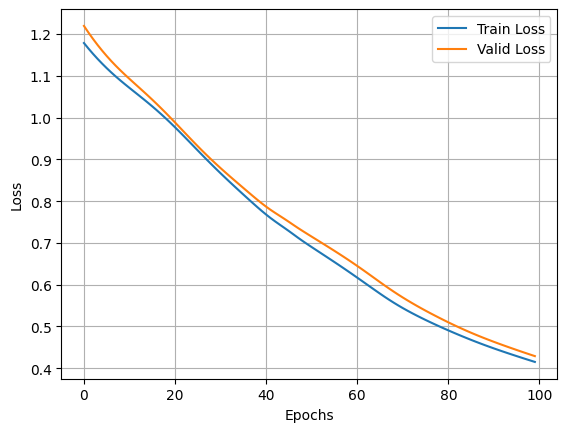

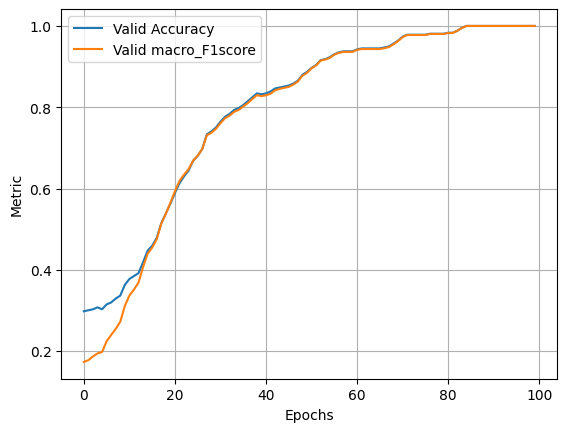

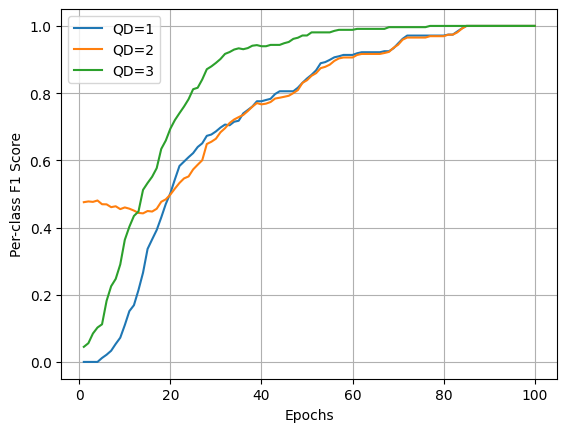

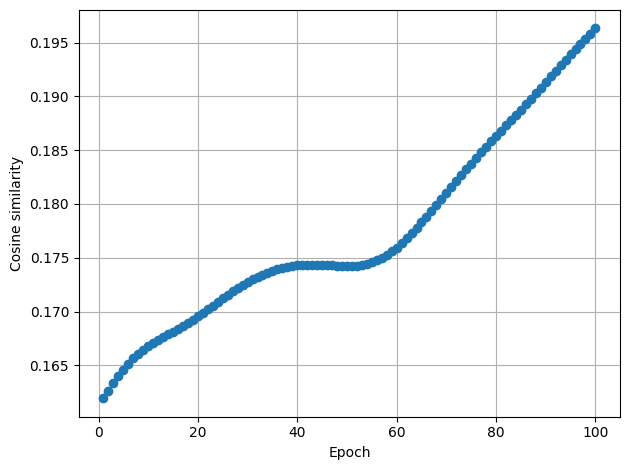

In [ ]:
all_preds1_1, topk_probs1_1,valid_accuracies1_1, valid_macroF1s1_1, valid_perF1s1_1 = main(train_data1, valid_data1, epoch, float("-inf"), early_stop, topk, with_mask=True)

In [ ]:
all_token = []
last_batch = list(valid_data1)[0]
last_inputs = last_batch["input_ids"]
last_labels = last_batch["labels"]
print("Type1 Valid")
for i,eg in enumerate(last_inputs.tolist()):
    input_token = detokenization(eg, idx2tok)
    a = ["" if j=="<pad>" else j for j in input_token.split()]
    a = "".join(a)
    print(i, a)
    all_token.append(a)

Type1 Valid
0 ∀cI(c)
1 ∃x∀f∀aJ(xfa)
2 ∀r∃jC(rj)
3 ∃s∀x∀dL(sxd)
4 ∀yF(y)
5 ∀wY(w)
6 ∀i∀l∃bI(ilb)
7 ∀e∃wP(ew)
8 ∀n∃x∀rY(nxr)
9 ∀tJ(t)
10 ∃g∀m∀eS(gme)
11 ∃mT(m)
12 ∀u∀z∃mT(uzm)
13 ∃g∃q∀pZ(gqp)
14 ∀s∀eG(se)
15 ∃s∃cD(sc)
16 ∀w∃x∃zI(wxz)
17 ∀aN(a)
18 ∃b∀kZ(bk)
19 ∀j∀sR(js)
20 ∀l∃rY(lr)
21 ∀j∀i∀pV(jip)
22 ∃n∃dE(nd)
23 ∀uA(u)
24 ∀v∃x∃eL(vxe)
25 ∀nX(n)
26 ∀o∀bL(ob)
27 ∃aV(a)
28 ∃nB(n)
29 ∃m∃zM(mz)
30 ∀i∃b∃yH(iby)
31 ∃oK(o)


In [ ]:
pad_id = 0
records = []
valid_batches = list(valid_data1)

for layer_idx, log_batches in logits_store.items():
    for batch_idx, logits_b in enumerate(log_batches):
        batch     = valid_batches[batch_idx]
        input_ids = batch["input_ids"]           # (B, L)
        labels    = batch["labels"]              # (B,)
        B, H, Lq, Lk = logits_b.shape

        pad_mask = (input_ids == pad_id)         # (B, L)
        mask4d   = pad_mask[:, None, None, :].to(device)

        masked_logits = logits_b.masked_fill(mask4d, float("-1e9"))
        attn_b = F.softmax(masked_logits, dim=-1)  # (B, H, Lq, Lk)

        vals_b = value_store[layer_idx][batch_idx]  # (B, H, Lq, Dv)

        for sample_idx in range(B):
            toks = input_ids[sample_idx].tolist()
            lbl  = int(labels[sample_idx].item())

            for head_idx in range(H):
                rec = {
                    "layer":  layer_idx,
                    "batch":  batch_idx,
                    "sample": sample_idx,
                    "head":   head_idx,
                    "tokens": toks,
                    "label":  lbl,
                    "logits": logits_b[sample_idx, head_idx].cpu().tolist(),
                    "attn":   attn_b[sample_idx, head_idx].cpu().tolist(),
                    "values": vals_b[sample_idx, head_idx].cpu().tolist(),
                }
                records.append(rec)

with open("valid_type1.json", "w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)

print(f"Saved {len(records)} records")

In [ ]:
error_case(test_all_preds_1_1, test_topk_probs_1_1)

Input token: ∀s∃b∀mX(sbm)
Label: 3
Prediction: 3


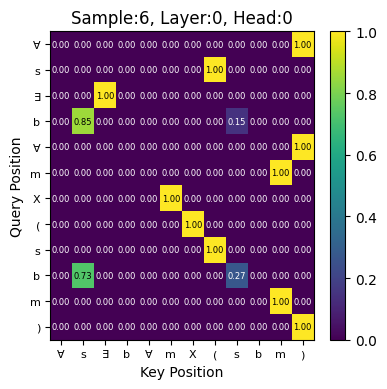

<Figure size 640x480 with 0 Axes>

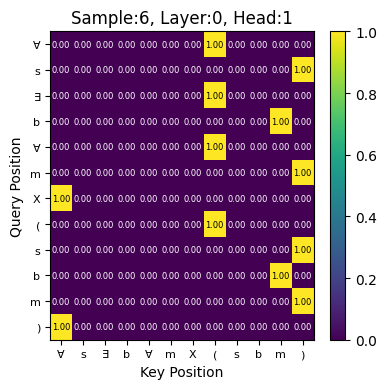

<Figure size 640x480 with 0 Axes>

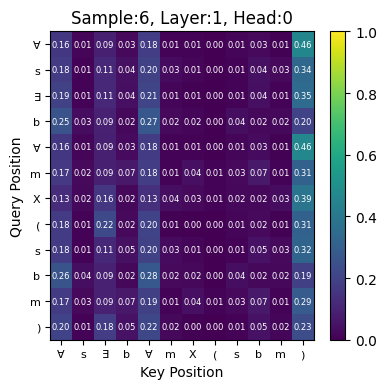

<Figure size 640x480 with 0 Axes>

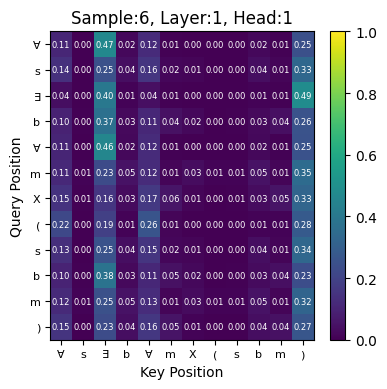

<Figure size 640x480 with 0 Axes>

In [ ]:
attetion_info(sample_idx=6, all_preds=test_all_preds_1_1)

## Standard-2

In [ ]:
with open("Type2_M.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

In [ ]:
data_name = "Type2"

In [ ]:
train_data2, valid_data2, test_data2 = preprocess("Type2_M.json", with_bos=True, without_comma=True)

In [ ]:
lr = 1e-5
epoch = 30
n_layers = 2
n_heads = 2

In [ ]:
torch.cuda.empty_cache()
attention_weights_store = defaultdict(list)
logits_store = defaultdict(list)
value_store = defaultdict(list)

In [ ]:
model = Classifier(vocb_size=enc_voc_size,
          max_len=max_len,
          d_model=d_model,
          n_heads=n_heads,
          n_classes=n_classes,
          dropout=dropout).to(device)

optimizer = AdamW(params=model.parameters(), lr=lr)

Type2


  0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0675


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 1.03, Val Loss: 0.95
Val Accuracy: 0.62, Val macroF1: 0.59
Val_F1 QD=1: 0.74,  QD=2: 0.38,  QD=3: 0.64


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0674


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.87, Val Loss: 0.79
Val Accuracy: 0.70, Val macroF1: 0.66
Val_F1 QD=1: 0.85,  QD=2: 0.44,  QD=3: 0.70


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0673


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.72, Val Loss: 0.65
Val Accuracy: 0.77, Val macroF1: 0.75
Val_F1 QD=1: 0.93,  QD=2: 0.58,  QD=3: 0.72


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0672


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.61, Val Loss: 0.56
Val Accuracy: 0.80, Val macroF1: 0.78
Val_F1 QD=1: 0.96,  QD=2: 0.65,  QD=3: 0.73


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0672


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.53, Val Loss: 0.50
Val Accuracy: 0.81, Val macroF1: 0.79
Val_F1 QD=1: 0.96,  QD=2: 0.67,  QD=3: 0.73


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.47, Val Loss: 0.43
Val Accuracy: 0.84, Val macroF1: 0.82
Val_F1 QD=1: 0.94,  QD=2: 0.73,  QD=3: 0.79


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.41, Val Loss: 0.40
Val Accuracy: 0.83, Val macroF1: 0.81
Val_F1 QD=1: 0.94,  QD=2: 0.71,  QD=3: 0.79


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.37, Val Loss: 0.37
Val Accuracy: 0.83, Val macroF1: 0.81
Val_F1 QD=1: 0.94,  QD=2: 0.71,  QD=3: 0.79


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.36, Val Loss: 0.36
Val Accuracy: 0.83, Val macroF1: 0.81
Val_F1 QD=1: 0.94,  QD=2: 0.70,  QD=3: 0.78


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.35, Val Loss: 0.35
Val Accuracy: 0.84, Val macroF1: 0.82
Val_F1 QD=1: 0.95,  QD=2: 0.72,  QD=3: 0.79


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 0.33, Val Loss: 0.34
Val Accuracy: 0.85, Val macroF1: 0.83
Val_F1 QD=1: 0.95,  QD=2: 0.73,  QD=3: 0.80


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Train Loss: 0.32, Val Loss: 0.33
Val Accuracy: 0.85, Val macroF1: 0.84
Val_F1 QD=1: 0.96,  QD=2: 0.75,  QD=3: 0.80


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 13, Train Loss: 0.31, Val Loss: 0.32
Val Accuracy: 0.86, Val macroF1: 0.84
Val_F1 QD=1: 0.96,  QD=2: 0.75,  QD=3: 0.81


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 14, Train Loss: 0.30, Val Loss: 0.31
Val Accuracy: 0.86, Val macroF1: 0.84
Val_F1 QD=1: 0.96,  QD=2: 0.75,  QD=3: 0.81


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 15, Train Loss: 0.37, Val Loss: 0.40
Val Accuracy: 0.83, Val macroF1: 0.81
Val_F1 QD=1: 0.97,  QD=2: 0.69,  QD=3: 0.78


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0670


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 16, Train Loss: 0.38, Val Loss: 0.37
Val Accuracy: 0.85, Val macroF1: 0.85
Val_F1 QD=1: 0.98,  QD=2: 0.75,  QD=3: 0.80


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0670


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 17, Train Loss: 0.34, Val Loss: 0.34
Val Accuracy: 0.87, Val macroF1: 0.86
Val_F1 QD=1: 0.99,  QD=2: 0.78,  QD=3: 0.80


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0670


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 18, Train Loss: 0.31, Val Loss: 0.30
Val Accuracy: 0.90, Val macroF1: 0.89
Val_F1 QD=1: 1.00,  QD=2: 0.83,  QD=3: 0.85


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0670


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 19, Train Loss: 0.25, Val Loss: 0.22
Val Accuracy: 0.94, Val macroF1: 0.93
Val_F1 QD=1: 0.99,  QD=2: 0.88,  QD=3: 0.91


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 20, Train Loss: 0.19, Val Loss: 0.16
Val Accuracy: 0.97, Val macroF1: 0.97
Val_F1 QD=1: 0.99,  QD=2: 0.95,  QD=3: 0.96


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 21, Train Loss: 0.13, Val Loss: 0.11
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.97,  QD=3: 0.98


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 22, Train Loss: 0.10, Val Loss: 0.09
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 23, Train Loss: 0.09, Val Loss: 0.08
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 24, Train Loss: 0.07, Val Loss: 0.07
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.99


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 25, Train Loss: 0.06, Val Loss: 0.06
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 0.99,  QD=3: 1.00


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 26, Train Loss: 0.05, Val Loss: 0.05
Val Accuracy: 1.00, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.99,  QD=3: 0.99


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 27, Train Loss: 0.05, Val Loss: 0.04
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 28, Train Loss: 0.04, Val Loss: 0.04
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 29, Train Loss: 0.03, Val Loss: 0.03
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


Train:   0%|          | 0/112 [00:00<?, ?it/s]

Quantifier cos_similarity: -0.0669


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 30, Train Loss: 0.03, Val Loss: 0.03
Val Accuracy: 1.00, Val macroF1: 1.00
Val_F1 QD=1: 1.00,  QD=2: 1.00,  QD=3: 1.00


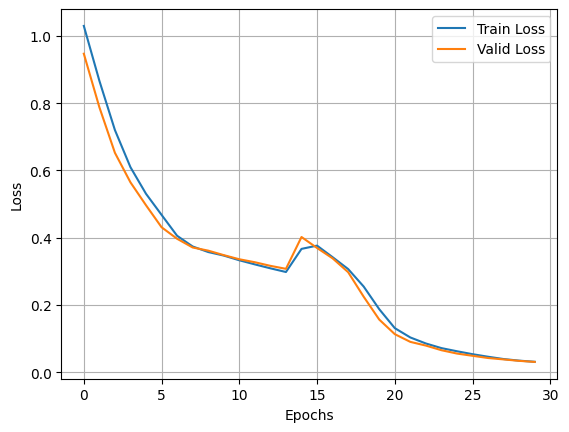

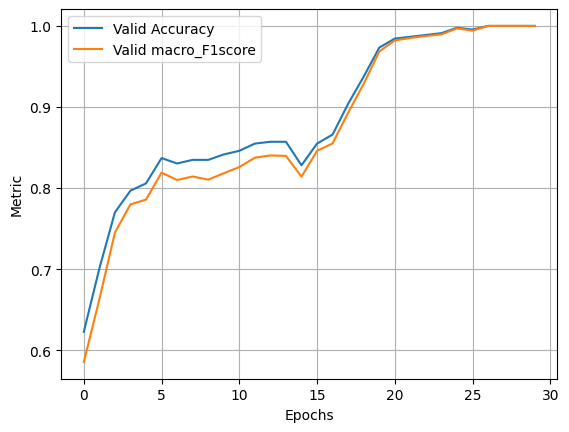

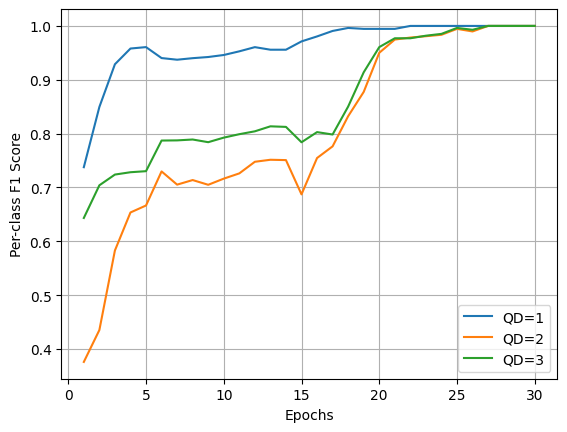

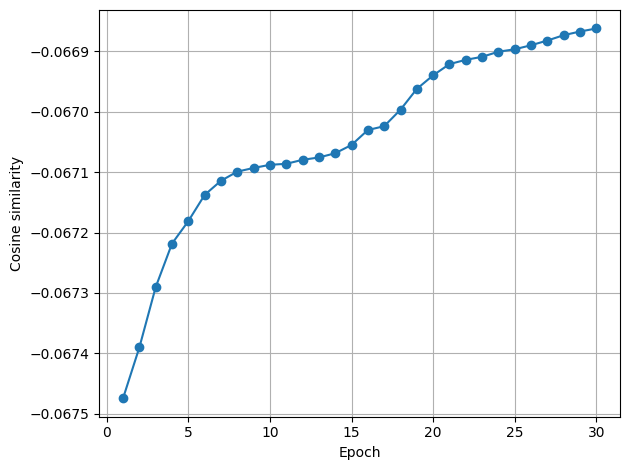

In [ ]:
all_preds2_1, topk_probs2_1,valid_accuracies2_1, valid_macroF1s2_1, valid_perF1s2_1 = main(train_data2, valid_data2, epoch, float("-inf"), early_stop, topk, with_mask=True)

In [ ]:
draw_confusion_matrix(
    loader=valid_data2,
    name = "Type2 ",
    all_preds=all_preds2_1,
    display_labels=["QD=1","QD=2","QD=3"]
)

In [ ]:
pad_id = 0
records2 = []
valid_batches = list(valid_data2)

for layer_idx, log_batches in logits_store.items():
    for batch_idx, logits_b in enumerate(log_batches):
        batch     = valid_batches[batch_idx]
        input_ids = batch["input_ids"]           # (B, L)
        labels    = batch["labels"]              # (B,)
        B, H, Lq, Lk = logits_b.shape

        pad_mask = (input_ids == pad_id)         # (B, L)
        mask4d   = pad_mask[:, None, None, :].to(device)

        masked_logits = logits_b.masked_fill(mask4d, float("-1e9"))
        attn_b = F.softmax(masked_logits, dim=-1)  # (B, H, Lq, Lk)

        vals_b = value_store[layer_idx][batch_idx]  # (B, H, Lq, Dv)

        for sample_idx in range(B):
            toks = input_ids[sample_idx].tolist()
            lbl  = int(labels[sample_idx].item())

            for head_idx in range(H):
                rec = {
                    "layer":  layer_idx,
                    "batch":  batch_idx,
                    "sample": sample_idx,
                    "head":   head_idx,
                    "tokens": toks,
                    "label":  lbl,
                    "logits": logits_b[sample_idx, head_idx].cpu().tolist(),
                    "attn":   attn_b[sample_idx, head_idx].cpu().tolist(),
                    "values": vals_b[sample_idx, head_idx].cpu().tolist(),
                }
                records2.append(rec)

with open("valid_type2.json", "w", encoding="utf-8") as f:
    json.dump(records2, f, ensure_ascii=False, indent=2)

print(f"Saved {len(records2)} records2")

Saved 128 records2


In [ ]:
test_acc_2_1, test_macroF1_2_1, test_perF1_2_1, test_all_preds_2_1, test_topk_probs_2_1 = test(test_data2, model, loss_fn, device, topk, with_mask=True)

In [ ]:
print(f'Type2_1\ntest_acc:{test_acc_2_1:.4f}, test_macroF1: {test_macroF1_2_1:.4f}, test_perF1: {test_perF1_2_1}')

### Attention Heatmaps

In [ ]:
all_token = []
last_batch = list(valid_data2)[-1]
last_inputs = last_batch["input_ids"]
last_labels = last_batch["labels"]
print("Type2 Valid")
for i,eg in enumerate(last_inputs.tolist()):
    input_token = detokenization(eg, idx2tok)
    a = ["" if j=="<pad>" else j for j in input_token.split()]
    a = "".join(a)
    print(i, a)
    all_token.append(a)

Type2 Valid
0 ∀bV(b)∧∀o∃q∀cR(oqc)
1 ∀z∃b∃aY(zba)∨∀u∃j∃pT(ujp)
2 ∃g∃sJ(gs)∧∃l∃iH(li)
3 ∀zC(z)∨∃hR(h)
4 ∃iT(i)∨∀r∃m∃oB(rmo)
5 ∀rV(r)→∀h∃l∀qU(hlq)
6 ∃m∃yV(my)∨∀aE(a)
7 ∀n∀bJ(nb)∧∀w∀eU(we)
8 ∃m∃lH(ml)→∃f∀xO(fx)
9 ∃nJ(n)→∀fG(f)
10 ∀qA(q)∧∀dD(d)
11 ∀m∃eW(me)→∃u∀tC(ut)
12 ∃l∀xT(lx)∨∀p∃vR(pv)
13 ∃jY(j)∧∀fO(f)
14 ∀rD(r)∨∃c∀o∃aO(coa)
15 ∃v∀kD(vk)∨∃fR(f)
16 ∀sK(s)∨∃oN(o)
17 ∃vB(v)→∀l∃f∀zC(lfz)
18 ∃iA(i)∨∀xK(x)
19 ∃g∀hY(gh)∧∀d∀iX(di)
20 ∀vJ(v)∧∀cA(c)
21 ∃w∃rH(wr)∧∃e∀zN(ez)
22 ∃s∀dC(sd)∨∀q∃nN(qn)
23 ∃d∀j∃vI(djv)→∀eE(e)
24 ∃gS(g)∧∃qV(q)
25 ∃iS(i)→∀hP(h)
26 ∀oH(o)∨∃t∃kR(tk)
27 ∃hY(h)∧∀l∃nE(ln)
28 ∃h∃vB(hv)∨∃d∃oE(do)
29 ∀vJ(v)→∀x∀nR(xn)
30 ∀z∃q∀dR(zqd)∨∃c∀l∀kF(clk)
31 ∀bQ(b)→∃nC(n)


Input token: ∀bQ(b)→∃nC(n)------------
Label: 1
Prediction: 1


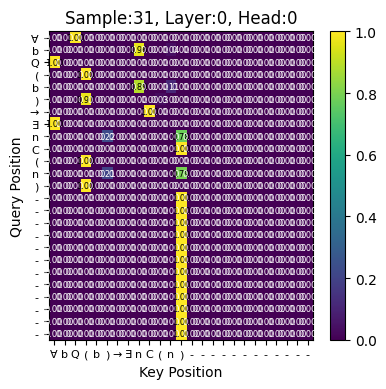

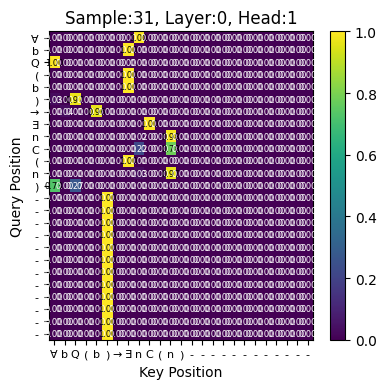

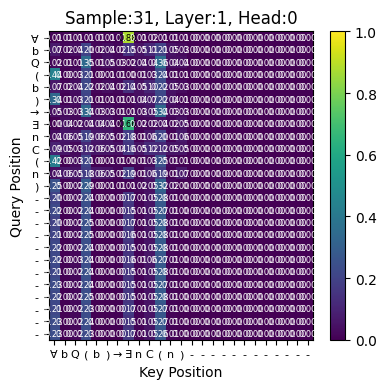

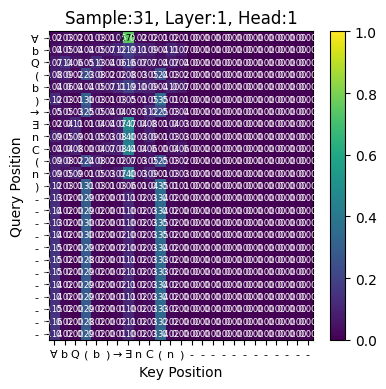

In [ ]:
attetion_info(sample_idx=31, all_preds=all_preds2_1)

## Standard-3

In [ ]:
with open("Type3_M.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

In [ ]:
data_name = "Type3"

In [ ]:
train_data3, valid_data3, test_data3 = preprocess("Type3_M.json", with_bos=False, without_comma=True)

In [ ]:
lr = 1e-5
epoch = 30
n_layers = 2
n_heads = 2

In [ ]:
model = Classifier(vocb_size=enc_voc_size,
          max_len=max_len,
          d_model=d_model,
          n_heads=n_heads,
          n_classes=n_classes,
          dropout=dropout).to(device)

optimizer = AdamW(params=model.parameters(), lr=lr)

In [ ]:
torch.cuda.empty_cache()
attention_weights_store = defaultdict(list)

In [ ]:
all_preds3_1, topk_probs3_1,valid_accuracies3_1, valid_macroF1s3_1, valid_perF1s3_1 = main(train_data3, valid_data3, epoch, float("-inf"), early_stop, topk, with_mask=True)

In [ ]:
draw_confusion_matrix(
    loader=valid_data3,
    name = "Type3 ",
    all_preds=all_preds3_1,
    display_labels=["QD=1","QD=2","QD=3"]
)

In [ ]:
test_acc_3_1, test_macroF1_3_1, test_perF1_3_1, test_all_preds_3_1, test_topk_probs_3_1 = test(test_data3, model, loss_fn, device, topk, with_mask=True)

In [ ]:
print(f'Type3_1\ntest_acc:{test_acc_3_1:.4f}, test_macroF1: {test_macroF1_3_1:.4f}, test_perF1: {test_perF1_3_1}')

### Attention Heatmaps

In [ ]:
all_token = []
last_batch = list(test_data3)[-1]
last_inputs = last_batch["input_ids"]
last_labels = last_batch["labels"]
print("Type3 Test")
for i,eg in enumerate(last_inputs.tolist()):
    input_token = detokenization(eg, idx2tok)
    a = ["" if j=="<pad>" else j for j in input_token.split()]
    a = "".join(a)
    print(i, a)
    all_token.append(a)

In [ ]:
error_case(test_all_preds_3_1, test_topk_probs_3_1)

In [ ]:
attetion_info(sample_idx=0, all_preds=test_all_preds_3_1)

## Nested-1

In [ ]:
with open("Type4_M.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

In [ ]:
data_name = "Type4"

In [ ]:
train_data4, valid_data4, test_data4 = preprocess("Type4_M.json", with_bos=True, without_comma=True)

In [ ]:
lr = 1e-5
epoch = 30
n_layers = 2
n_heads = 2

In [ ]:
torch.cuda.empty_cache()
attention_weights_store = defaultdict(list)
logits_store = defaultdict(list)
value_store = defaultdict(list)

In [ ]:
model = Classifier(vocb_size=enc_voc_size,
          max_len=max_len,
          d_model=d_model,
          n_heads=n_heads,
          n_classes=n_classes,
          dropout=dropout).to(device)

optimizer = AdamW(params=model.parameters(), lr=lr)

Type1


  0%|          | 0/100 [00:00<?, ?it/s]

Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1507


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 1.18, Val Loss: 1.15
Val Accuracy: 0.34, Val macroF1: 0.17
Val_F1 QD=1: 0.50,  QD=2: 0.00,  QD=3: 0.00


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1507


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 1.15, Val Loss: 1.12
Val Accuracy: 0.36, Val macroF1: 0.20
Val_F1 QD=1: 0.51,  QD=2: 0.00,  QD=3: 0.10


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1509


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 1.12, Val Loss: 1.09
Val Accuracy: 0.39, Val macroF1: 0.25
Val_F1 QD=1: 0.53,  QD=2: 0.00,  QD=3: 0.21


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1511


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 1.09, Val Loss: 1.07
Val Accuracy: 0.45, Val macroF1: 0.33
Val_F1 QD=1: 0.56,  QD=2: 0.01,  QD=3: 0.43


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1513


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 1.07, Val Loss: 1.05
Val Accuracy: 0.50, Val macroF1: 0.39
Val_F1 QD=1: 0.59,  QD=2: 0.01,  QD=3: 0.58


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1517


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 1.05, Val Loss: 1.03
Val Accuracy: 0.55, Val macroF1: 0.44
Val_F1 QD=1: 0.61,  QD=2: 0.02,  QD=3: 0.70


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1521


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 1.03, Val Loss: 1.01
Val Accuracy: 0.59, Val macroF1: 0.49
Val_F1 QD=1: 0.63,  QD=2: 0.06,  QD=3: 0.78


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1526


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 1.01, Val Loss: 0.99
Val Accuracy: 0.65, Val macroF1: 0.56
Val_F1 QD=1: 0.67,  QD=2: 0.13,  QD=3: 0.88


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1531


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.99, Val Loss: 0.97
Val Accuracy: 0.68, Val macroF1: 0.59
Val_F1 QD=1: 0.69,  QD=2: 0.19,  QD=3: 0.91


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1536


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.97, Val Loss: 0.96
Val Accuracy: 0.70, Val macroF1: 0.62
Val_F1 QD=1: 0.70,  QD=2: 0.22,  QD=3: 0.93


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1542


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 11, Train Loss: 0.96, Val Loss: 0.94
Val Accuracy: 0.71, Val macroF1: 0.63
Val_F1 QD=1: 0.72,  QD=2: 0.24,  QD=3: 0.95


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1549


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 12, Train Loss: 0.94, Val Loss: 0.92
Val Accuracy: 0.73, Val macroF1: 0.65
Val_F1 QD=1: 0.73,  QD=2: 0.28,  QD=3: 0.95


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1555


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 13, Train Loss: 0.92, Val Loss: 0.91
Val Accuracy: 0.75, Val macroF1: 0.68
Val_F1 QD=1: 0.75,  QD=2: 0.35,  QD=3: 0.94


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1562


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 14, Train Loss: 0.91, Val Loss: 0.89
Val Accuracy: 0.75, Val macroF1: 0.69
Val_F1 QD=1: 0.76,  QD=2: 0.36,  QD=3: 0.93


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1570


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 15, Train Loss: 0.90, Val Loss: 0.88
Val Accuracy: 0.76, Val macroF1: 0.69
Val_F1 QD=1: 0.77,  QD=2: 0.36,  QD=3: 0.93


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1577


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 16, Train Loss: 0.88, Val Loss: 0.87
Val Accuracy: 0.75, Val macroF1: 0.69
Val_F1 QD=1: 0.78,  QD=2: 0.36,  QD=3: 0.91


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1584


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 17, Train Loss: 0.87, Val Loss: 0.86
Val Accuracy: 0.75, Val macroF1: 0.67
Val_F1 QD=1: 0.79,  QD=2: 0.32,  QD=3: 0.90


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1592


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 18, Train Loss: 0.86, Val Loss: 0.84
Val Accuracy: 0.74, Val macroF1: 0.66
Val_F1 QD=1: 0.80,  QD=2: 0.31,  QD=3: 0.88


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1599


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 19, Train Loss: 0.85, Val Loss: 0.83
Val Accuracy: 0.74, Val macroF1: 0.66
Val_F1 QD=1: 0.80,  QD=2: 0.31,  QD=3: 0.87


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1606


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 20, Train Loss: 0.83, Val Loss: 0.82
Val Accuracy: 0.74, Val macroF1: 0.66
Val_F1 QD=1: 0.81,  QD=2: 0.31,  QD=3: 0.86


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1613


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 21, Train Loss: 0.82, Val Loss: 0.81
Val Accuracy: 0.74, Val macroF1: 0.65
Val_F1 QD=1: 0.82,  QD=2: 0.30,  QD=3: 0.84


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1619


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 22, Train Loss: 0.82, Val Loss: 0.80
Val Accuracy: 0.73, Val macroF1: 0.65
Val_F1 QD=1: 0.83,  QD=2: 0.28,  QD=3: 0.83


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1625


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 23, Train Loss: 0.81, Val Loss: 0.80
Val Accuracy: 0.73, Val macroF1: 0.65
Val_F1 QD=1: 0.85,  QD=2: 0.29,  QD=3: 0.81


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1630


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 24, Train Loss: 0.80, Val Loss: 0.79
Val Accuracy: 0.74, Val macroF1: 0.66
Val_F1 QD=1: 0.85,  QD=2: 0.31,  QD=3: 0.81


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1635


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 25, Train Loss: 0.79, Val Loss: 0.78
Val Accuracy: 0.74, Val macroF1: 0.66
Val_F1 QD=1: 0.86,  QD=2: 0.31,  QD=3: 0.81


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1640


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 26, Train Loss: 0.78, Val Loss: 0.77
Val Accuracy: 0.75, Val macroF1: 0.67
Val_F1 QD=1: 0.87,  QD=2: 0.33,  QD=3: 0.81


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1645


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 27, Train Loss: 0.77, Val Loss: 0.76
Val Accuracy: 0.75, Val macroF1: 0.67
Val_F1 QD=1: 0.87,  QD=2: 0.34,  QD=3: 0.81


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1650


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 28, Train Loss: 0.76, Val Loss: 0.75
Val Accuracy: 0.76, Val macroF1: 0.68
Val_F1 QD=1: 0.87,  QD=2: 0.36,  QD=3: 0.81


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1655


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 29, Train Loss: 0.75, Val Loss: 0.74
Val Accuracy: 0.76, Val macroF1: 0.69
Val_F1 QD=1: 0.88,  QD=2: 0.38,  QD=3: 0.81


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1661


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 30, Train Loss: 0.74, Val Loss: 0.73
Val Accuracy: 0.77, Val macroF1: 0.71
Val_F1 QD=1: 0.88,  QD=2: 0.42,  QD=3: 0.82


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1666


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 31, Train Loss: 0.73, Val Loss: 0.72
Val Accuracy: 0.79, Val macroF1: 0.74
Val_F1 QD=1: 0.89,  QD=2: 0.50,  QD=3: 0.83


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1671


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 32, Train Loss: 0.72, Val Loss: 0.71
Val Accuracy: 0.81, Val macroF1: 0.77
Val_F1 QD=1: 0.89,  QD=2: 0.56,  QD=3: 0.85


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1677


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 33, Train Loss: 0.71, Val Loss: 0.70
Val Accuracy: 0.81, Val macroF1: 0.77
Val_F1 QD=1: 0.90,  QD=2: 0.56,  QD=3: 0.85


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1683


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 34, Train Loss: 0.70, Val Loss: 0.69
Val Accuracy: 0.83, Val macroF1: 0.80
Val_F1 QD=1: 0.90,  QD=2: 0.64,  QD=3: 0.87


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1689


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 35, Train Loss: 0.69, Val Loss: 0.68
Val Accuracy: 0.85, Val macroF1: 0.82
Val_F1 QD=1: 0.91,  QD=2: 0.68,  QD=3: 0.88


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1696


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 36, Train Loss: 0.67, Val Loss: 0.67
Val Accuracy: 0.86, Val macroF1: 0.84
Val_F1 QD=1: 0.91,  QD=2: 0.72,  QD=3: 0.90


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1702


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 37, Train Loss: 0.66, Val Loss: 0.65
Val Accuracy: 0.87, Val macroF1: 0.85
Val_F1 QD=1: 0.91,  QD=2: 0.73,  QD=3: 0.90


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1709


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 38, Train Loss: 0.65, Val Loss: 0.64
Val Accuracy: 0.88, Val macroF1: 0.87
Val_F1 QD=1: 0.92,  QD=2: 0.78,  QD=3: 0.92


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1715


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 39, Train Loss: 0.64, Val Loss: 0.63
Val Accuracy: 0.89, Val macroF1: 0.88
Val_F1 QD=1: 0.92,  QD=2: 0.79,  QD=3: 0.92


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1721


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 40, Train Loss: 0.63, Val Loss: 0.62
Val Accuracy: 0.89, Val macroF1: 0.87
Val_F1 QD=1: 0.91,  QD=2: 0.79,  QD=3: 0.92


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1728


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 41, Train Loss: 0.62, Val Loss: 0.61
Val Accuracy: 0.89, Val macroF1: 0.88
Val_F1 QD=1: 0.91,  QD=2: 0.80,  QD=3: 0.93


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1734


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 42, Train Loss: 0.61, Val Loss: 0.61
Val Accuracy: 0.90, Val macroF1: 0.89
Val_F1 QD=1: 0.91,  QD=2: 0.81,  QD=3: 0.94


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1740


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 43, Train Loss: 0.61, Val Loss: 0.60
Val Accuracy: 0.90, Val macroF1: 0.89
Val_F1 QD=1: 0.91,  QD=2: 0.82,  QD=3: 0.94


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1746


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 44, Train Loss: 0.60, Val Loss: 0.59
Val Accuracy: 0.90, Val macroF1: 0.90
Val_F1 QD=1: 0.92,  QD=2: 0.83,  QD=3: 0.94


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1752


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 45, Train Loss: 0.59, Val Loss: 0.58
Val Accuracy: 0.91, Val macroF1: 0.90
Val_F1 QD=1: 0.92,  QD=2: 0.84,  QD=3: 0.95


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1757


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 46, Train Loss: 0.58, Val Loss: 0.58
Val Accuracy: 0.92, Val macroF1: 0.91
Val_F1 QD=1: 0.93,  QD=2: 0.86,  QD=3: 0.96


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1762


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 47, Train Loss: 0.58, Val Loss: 0.57
Val Accuracy: 0.92, Val macroF1: 0.92
Val_F1 QD=1: 0.93,  QD=2: 0.86,  QD=3: 0.96


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1767


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 48, Train Loss: 0.57, Val Loss: 0.56
Val Accuracy: 0.93, Val macroF1: 0.93
Val_F1 QD=1: 0.94,  QD=2: 0.88,  QD=3: 0.96


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1772


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 49, Train Loss: 0.56, Val Loss: 0.55
Val Accuracy: 0.94, Val macroF1: 0.93
Val_F1 QD=1: 0.94,  QD=2: 0.89,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1776


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 50, Train Loss: 0.55, Val Loss: 0.55
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.95,  QD=2: 0.89,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1781


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 51, Train Loss: 0.55, Val Loss: 0.54
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.95,  QD=2: 0.90,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1785


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 52, Train Loss: 0.54, Val Loss: 0.53
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.95,  QD=2: 0.90,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1789


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 53, Train Loss: 0.53, Val Loss: 0.53
Val Accuracy: 0.94, Val macroF1: 0.94
Val_F1 QD=1: 0.95,  QD=2: 0.90,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1793


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 54, Train Loss: 0.53, Val Loss: 0.52
Val Accuracy: 0.95, Val macroF1: 0.94
Val_F1 QD=1: 0.96,  QD=2: 0.90,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1797


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 55, Train Loss: 0.52, Val Loss: 0.51
Val Accuracy: 0.95, Val macroF1: 0.95
Val_F1 QD=1: 0.96,  QD=2: 0.92,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1801


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 56, Train Loss: 0.52, Val Loss: 0.51
Val Accuracy: 0.95, Val macroF1: 0.95
Val_F1 QD=1: 0.96,  QD=2: 0.92,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1804


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 57, Train Loss: 0.51, Val Loss: 0.50
Val Accuracy: 0.95, Val macroF1: 0.95
Val_F1 QD=1: 0.96,  QD=2: 0.92,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1808


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 58, Train Loss: 0.50, Val Loss: 0.49
Val Accuracy: 0.96, Val macroF1: 0.96
Val_F1 QD=1: 0.97,  QD=2: 0.93,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1811


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 59, Train Loss: 0.50, Val Loss: 0.49
Val Accuracy: 0.96, Val macroF1: 0.96
Val_F1 QD=1: 0.97,  QD=2: 0.93,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1815


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 60, Train Loss: 0.49, Val Loss: 0.48
Val Accuracy: 0.96, Val macroF1: 0.96
Val_F1 QD=1: 0.97,  QD=2: 0.93,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1818


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 61, Train Loss: 0.49, Val Loss: 0.48
Val Accuracy: 0.96, Val macroF1: 0.96
Val_F1 QD=1: 0.97,  QD=2: 0.93,  QD=3: 0.97


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1821


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 62, Train Loss: 0.48, Val Loss: 0.47
Val Accuracy: 0.96, Val macroF1: 0.96
Val_F1 QD=1: 0.97,  QD=2: 0.94,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1824


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 63, Train Loss: 0.48, Val Loss: 0.47
Val Accuracy: 0.96, Val macroF1: 0.96
Val_F1 QD=1: 0.97,  QD=2: 0.94,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1827


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 64, Train Loss: 0.47, Val Loss: 0.46
Val Accuracy: 0.97, Val macroF1: 0.97
Val_F1 QD=1: 0.98,  QD=2: 0.94,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1830


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 65, Train Loss: 0.47, Val Loss: 0.46
Val Accuracy: 0.97, Val macroF1: 0.97
Val_F1 QD=1: 0.98,  QD=2: 0.95,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1833


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 66, Train Loss: 0.46, Val Loss: 0.45
Val Accuracy: 0.97, Val macroF1: 0.97
Val_F1 QD=1: 0.98,  QD=2: 0.96,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1836


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 67, Train Loss: 0.46, Val Loss: 0.45
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.96,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1838


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 68, Train Loss: 0.45, Val Loss: 0.44
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.96,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1841


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 69, Train Loss: 0.45, Val Loss: 0.44
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.96,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1844


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 70, Train Loss: 0.44, Val Loss: 0.43
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.97,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1847


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 71, Train Loss: 0.44, Val Loss: 0.43
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.96,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1849


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 72, Train Loss: 0.44, Val Loss: 0.42
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.96,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1852


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 73, Train Loss: 0.43, Val Loss: 0.42
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.97,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1855


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 74, Train Loss: 0.43, Val Loss: 0.42
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.97,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1857


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 75, Train Loss: 0.42, Val Loss: 0.41
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.97,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1860


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 76, Train Loss: 0.42, Val Loss: 0.41
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.97,  QD=3: 0.99


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1862


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 77, Train Loss: 0.42, Val Loss: 0.40
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.97,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1865


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 78, Train Loss: 0.41, Val Loss: 0.40
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.97,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1867


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 79, Train Loss: 0.41, Val Loss: 0.40
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.97,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1869


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 80, Train Loss: 0.40, Val Loss: 0.39
Val Accuracy: 0.98, Val macroF1: 0.98
Val_F1 QD=1: 0.99,  QD=2: 0.97,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1871


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 81, Train Loss: 0.40, Val Loss: 0.39
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1873


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 82, Train Loss: 0.39, Val Loss: 0.38
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1875


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 83, Train Loss: 0.39, Val Loss: 0.38
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1877


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 84, Train Loss: 0.39, Val Loss: 0.37
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1879


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 85, Train Loss: 0.38, Val Loss: 0.37
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1881


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 86, Train Loss: 0.38, Val Loss: 0.36
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1882


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 87, Train Loss: 0.37, Val Loss: 0.36
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1884


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 88, Train Loss: 0.37, Val Loss: 0.35
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1886


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 89, Train Loss: 0.36, Val Loss: 0.35
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1888


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 90, Train Loss: 0.36, Val Loss: 0.34
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1890


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 91, Train Loss: 0.35, Val Loss: 0.34
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1892


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 92, Train Loss: 0.35, Val Loss: 0.33
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1894


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 93, Train Loss: 0.34, Val Loss: 0.33
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1895


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 94, Train Loss: 0.34, Val Loss: 0.32
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1897


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 95, Train Loss: 0.33, Val Loss: 0.32
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1898


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 96, Train Loss: 0.33, Val Loss: 0.32
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1900


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 97, Train Loss: 0.32, Val Loss: 0.31
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1901


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 98, Train Loss: 0.32, Val Loss: 0.31
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1902


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 99, Train Loss: 0.32, Val Loss: 0.31
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Quantifier cos_similarity: 0.1902


Valid:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 100, Train Loss: 0.31, Val Loss: 0.30
Val Accuracy: 0.99, Val macroF1: 0.99
Val_F1 QD=1: 1.00,  QD=2: 0.98,  QD=3: 0.98


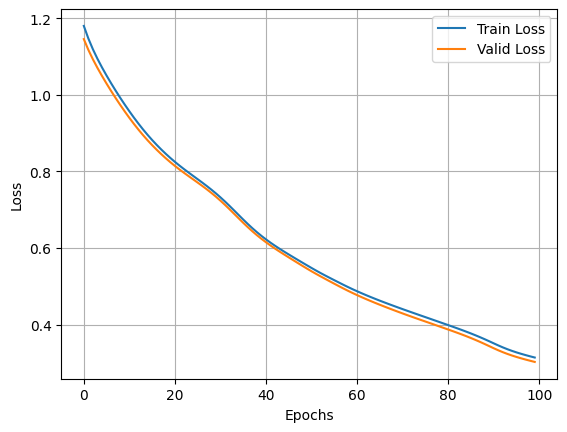

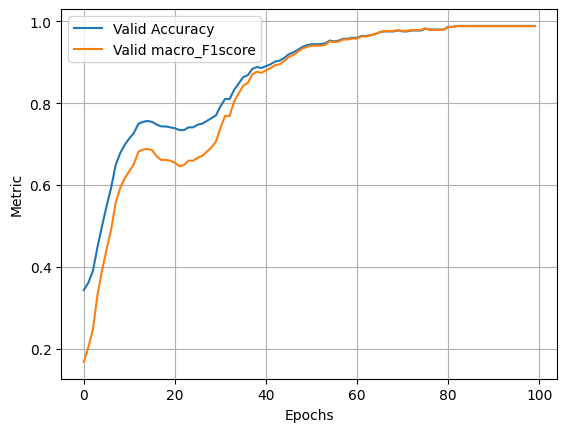

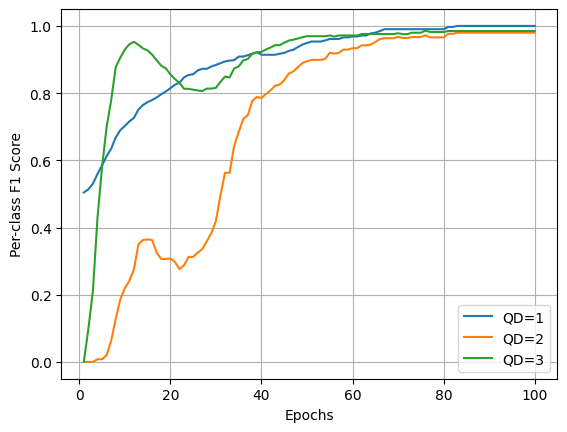

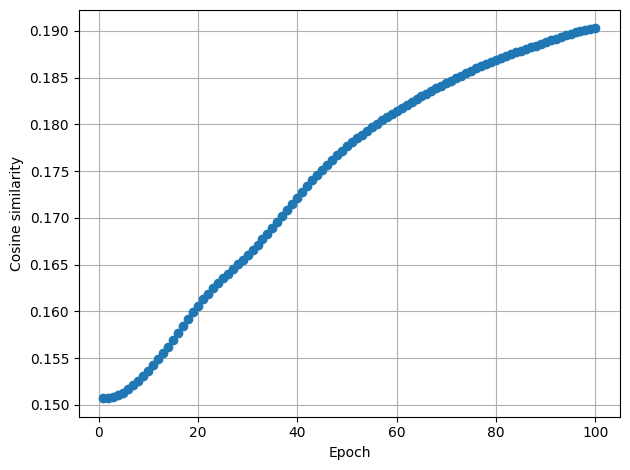

In [ ]:
all_preds4_1, topk_probs4_1, valid_accuracies4_1, valid_macroF1s4_1, valid_perF1s4_1 = main(train_data4, valid_data4, epoch, float("-inf"), early_stop, topk, with_mask=True)

In [ ]:
pad_id = 0
records4 = []
valid_batches = list(valid_data4)

for layer_idx, log_batches in logits_store.items():
    for batch_idx, logits_b in enumerate(log_batches):
        batch     = valid_batches[batch_idx]
        input_ids = batch["input_ids"]           # (B, L)
        labels    = batch["labels"]              # (B,)
        B, H, Lq, Lk = logits_b.shape

        pad_mask = (input_ids == pad_id)         # (B, L)
        mask4d   = pad_mask[:, None, None, :].to(device)

        masked_logits = logits_b.masked_fill(mask4d, float("-1e9"))
        attn_b = F.softmax(masked_logits, dim=-1)  # (B, H, Lq, Lk)

        vals_b = value_store[layer_idx][batch_idx]  # (B, H, Lq, Dv)

        for sample_idx in range(B):
            toks = input_ids[sample_idx].tolist()
            lbl  = int(labels[sample_idx].item())

            for head_idx in range(H):
                rec = {
                    "layer":  layer_idx,
                    "batch":  batch_idx,
                    "sample": sample_idx,
                    "head":   head_idx,
                    "tokens": toks,
                    "label":  lbl,
                    "logits": logits_b[sample_idx, head_idx].cpu().tolist(),
                    "attn":   attn_b[sample_idx, head_idx].cpu().tolist(),
                    "values": vals_b[sample_idx, head_idx].cpu().tolist(),
                }
                records4.append(rec)

with open("valid_type4.json", "w", encoding="utf-8") as f:
    json.dump(records4, f, ensure_ascii=False, indent=2)

print(f"Saved {len(records4)} records4")

Saved 128 records4


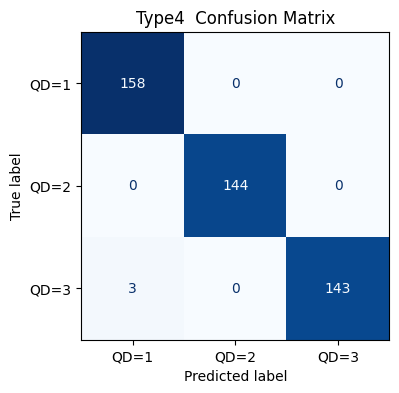

In [ ]:
draw_confusion_matrix(
    loader=valid_data4,
    name = "Type4 ",
    all_preds=all_preds4_1,
    display_labels=["QD=1","QD=2","QD=3"]
)

In [ ]:
test_acc_4_1, test_macroF1_4_1, test_perF1_4_1, test_all_preds_4_1, test_topk_probs_4_1 = test(test_data4, model, loss_fn, device, topk, with_mask=True)

In [ ]:
print(f'Type4_1\ntest_acc:{test_acc_4_1:.4f}, test_macroF1: {test_macroF1_4_1:.4f}, test_perF1: {test_perF1_4_1}')

### Attention Heatmaps

In [ ]:
all_token = []
last_batch = list(valid_data4)[0]
last_inputs = last_batch["input_ids"]
last_labels = last_batch["labels"]
print("Type4 Valid")
for i,eg in enumerate(last_inputs.tolist()):
    input_token = detokenization(eg, idx2tok)
    a = ["" if j=="<pad>" else j for j in input_token.split()]
    a = "".join(a)
    print(i, a)
    all_token.append(a)

Type4 Valid
0 ∀m(M(m)∧∀g(∀uE(gu)∨∀aS(ga)))
1 ∀d(K(d)∧∃vM(dv))
2 ∀m(A(m)→∃c(∀bP(cb)∧Y(c)))
3 ∀g(V(g)∧∀k(V(k)∧∃hF(h)))
4 ∃q(K(q)→Y(q))
5 ∃b(K(b)∧N(b))
6 ∃l(G(l)∧W(l))
7 ∀v(B(v)∧∀p(∀sX(ps)∧∀oT(po)))
8 ∀o(N(o)→S(o))
9 ∃g(D(g)∧∀f(W(f)∧∃yX(fy)))
10 ∃n(V(n)∨K(n))
11 ∃k(F(k)∨∀xS(kx))
12 ∃k(O(k)→P(k))
13 ∀i(A(i)∨U(i))
14 ∀e(W(e)∨V(e))
15 ∃g(M(g)→∃q(∀oJ(qo)∧∃bP(qb)))
16 ∀q(Q(q)→∀j(∀nZ(jn)∨∃vS(jv)))
17 ∀h(L(h)→∃yV(hy))
18 ∃s(∀fO(sf)→∀tF(t))
19 ∃j(∀mA(jm)∨D(j))
20 ∀i(K(i)→∃uM(u))
21 ∃f(∀vS(fv)∧∃yS(fy))
22 ∃r(P(r)∧W(r))
23 ∀a(L(a)→E(a))
24 ∃l(Y(l)→∃sO(s))
25 ∀c(C(c)∧Z(c))
26 ∀w(P(w)∧∀c(∀nL(cn)∧∃bE(b)))
27 ∃d(Y(d)→J(d))
28 ∃l(I(l)∨∃v(∃xB(vx)∧∃mJ(m)))
29 ∀p(Y(p)∨A(p))
30 ∀t(Z(t)→∃y(∃aW(ya)∨∀eK(ye)))
31 ∃z(T(z)→V(z))


Input token: ∃j(∀mA(jm)∨D(j))------------
Label: 2
Prediction: 2


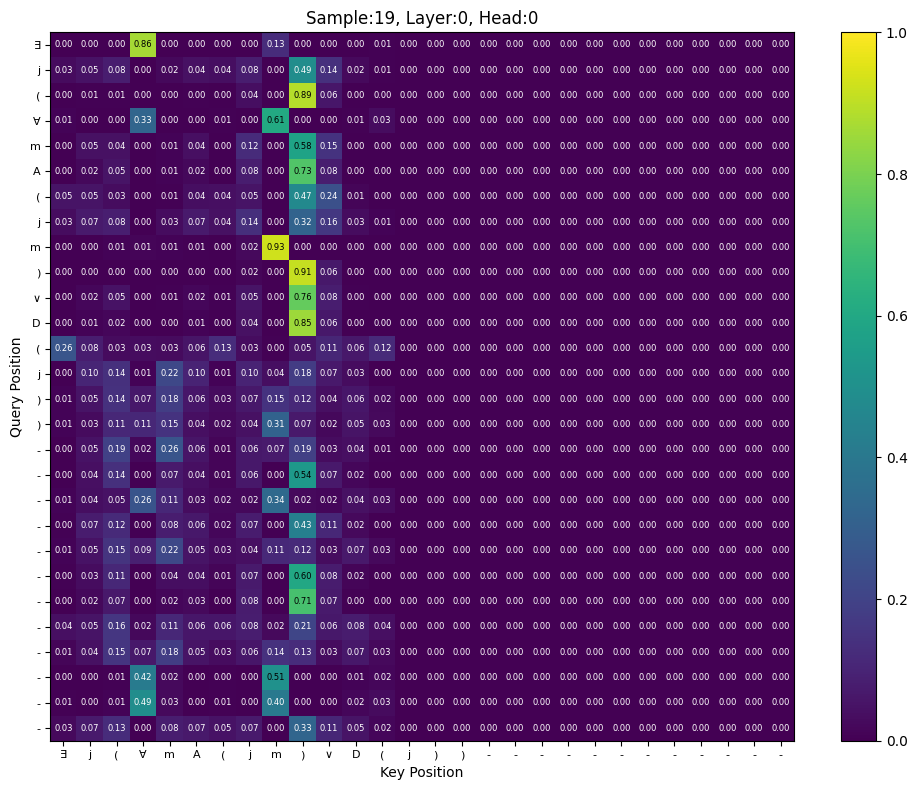

<Figure size 640x480 with 0 Axes>

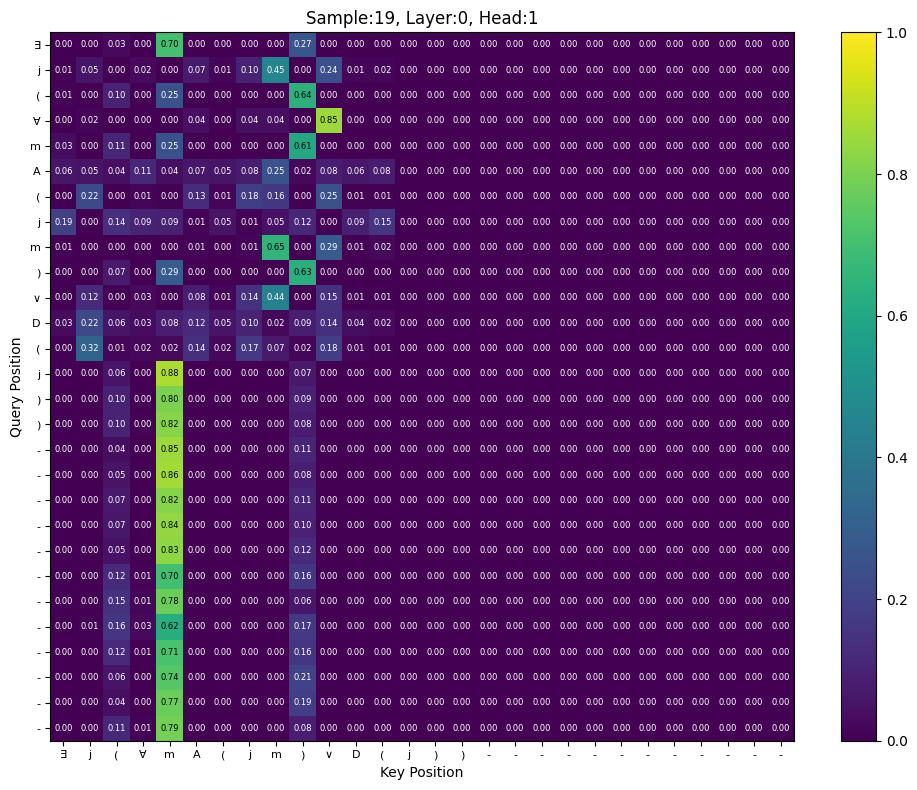

<Figure size 640x480 with 0 Axes>

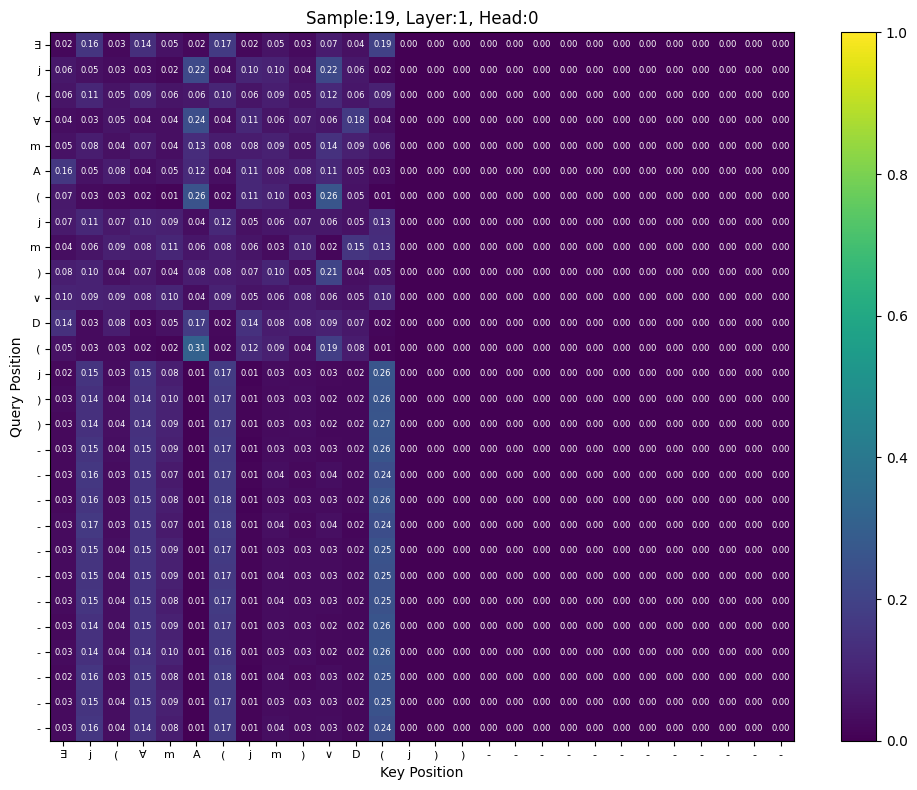

<Figure size 640x480 with 0 Axes>

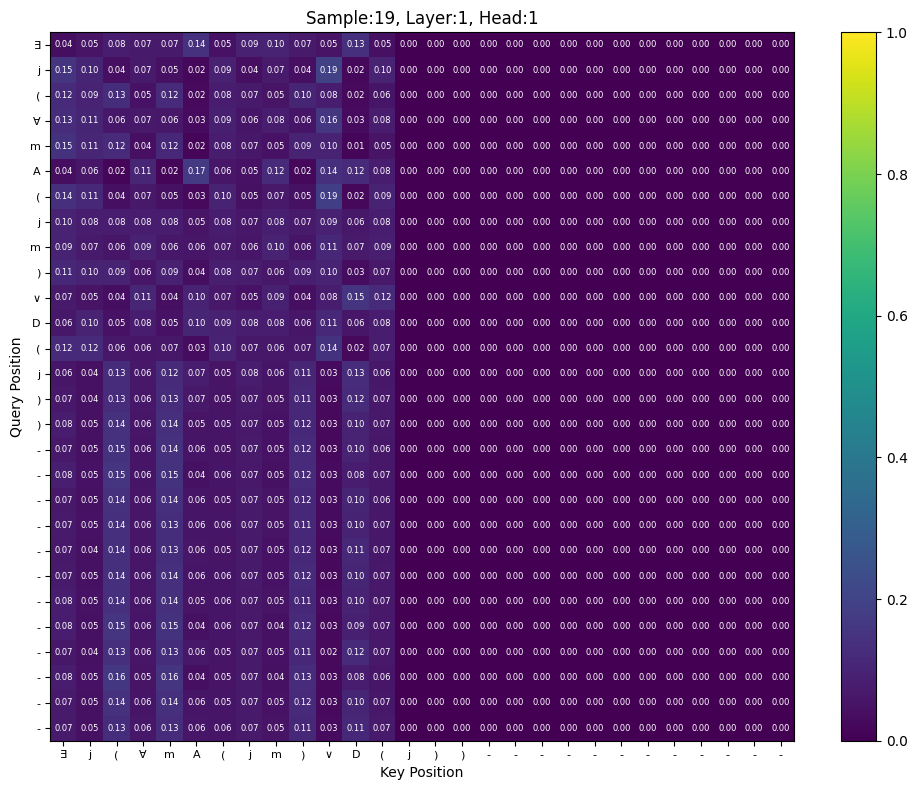

<Figure size 640x480 with 0 Axes>

In [ ]:
attetion_info(sample_idx=19, all_preds=all_preds1_1)

### Test

In [ ]:
all_token = []
last_batch = list(test_data4)[-1]
last_inputs = last_batch["input_ids"]
last_labels = last_batch["labels"]
print("Type4 Test")
for i,eg in enumerate(last_inputs.tolist()):
    input_token = detokenization(eg, idx2tok)
    a = ["" if j=="<pad>" else j for j in input_token.split()]
    a = "".join(a)
    print(i, a)
    all_token.append(a)

In [ ]:
error_case(test_all_preds_4_1, test_topk_probs_4_1)

In [ ]:
attetion_info(sample_idx=15, all_preds=test_all_preds_4_1)

## Type 5

In [ ]:
with open("FOL2NS_M.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)

In [ ]:
data_name = "Type5"

In [ ]:
train_data5, valid_data5, test_data5 = preprocess("FOL2NS_M.json", with_bos=False, without_comma=True)

In [ ]:
lr = 1e-5
epoch = 30
n_layers = 2
n_heads = 2

In [ ]:
model = Classifier(vocb_size=enc_voc_size,
          max_len=max_len,
          d_model=d_model,
          n_heads=n_heads,
          n_classes=n_classes,
          dropout=dropout).to(device)

optimizer = AdamW(params=model.parameters(), lr=lr)

In [ ]:
torch.cuda.empty_cache()
attention_weights_store = defaultdict(list)

In [ ]:
all_preds5_1, topk_probs5_1, valid_accuracies5_1, valid_macroF1s5_1, valid_perF1s5_1 = main(train_data5, valid_data5, epoch, float("-inf"), early_stop, topk, with_mask=True)

In [ ]:
draw_confusion_matrix(
    loader=valid_data5,
    name = "Type5 ",
    all_preds=all_preds5_1,
    display_labels=["QD=1","QD=2","QD=3"]
)

In [ ]:
test_acc_5_1, test_macroF1_5_1, test_perF1_5_1, test_all_preds_5_1, test_topk_probs_5_1 = test(test_data5, model, loss_fn, device, topk, with_mask=True)

In [ ]:
print(f'Type5_1\ntest_acc:{test_acc_5_1:.4f}, test_macroF1: {test_macroF1_5_1:.4f}, test_perF1: {test_perF1_5_1}')

### Attention Heatmaps

In [ ]:
all_token = []
last_batch = list(valid_data5)[-1]
last_inputs = last_batch["input_ids"]
last_labels = last_batch["labels"]
print("Type5 Test")
for i,eg in enumerate(last_inputs.tolist()):
    input_token = detokenization(eg, idx2tok)
    a = ["" if j=="<pad>" else j for j in input_token.split()]
    a = "".join(a)
    print(i, a)
    all_token.append(a)

In [ ]:
error_case(all_preds5_1, topk_probs5_1)

In [ ]:
attetion_info(sample_idx=31, all_preds=all_preds5_1)

### Test

In [ ]:
all_token = []
last_batch = list(test_data5)[-1]
last_inputs = last_batch["input_ids"]
last_labels = last_batch["labels"]
print("Type5 Test")
for i,eg in enumerate(last_inputs.tolist()):
    input_token = detokenization(eg, idx2tok)
    a = ["" if j=="<pad>" else j for j in input_token.split()]
    a = "".join(a)
    print(i, a)
    all_token.append(a)

In [ ]:
error_case(test_all_preds_5_1, test_topk_probs_5_1)

In [ ]:
attetion_info(sample_idx=30, all_preds=test_all_preds_5_1)